# The very first  (and very wrong) Cls computed using jax_cosmo

In [1]:
%pylab inline
import jax
import jax.numpy as np
from jax_cosmo.cosmology import cosmology, a2z, z2a
from jax_cosmo.kernels import get_lensing_efficiency_kernel

Populating the interactive namespace from numpy and matplotlib


In [2]:
# First, let's define some analytic dndz
def smail_nz(z, a=2.0, b=1.5,z0=0.9):
    return z**a * np.exp(-(z / z0)**b)

/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


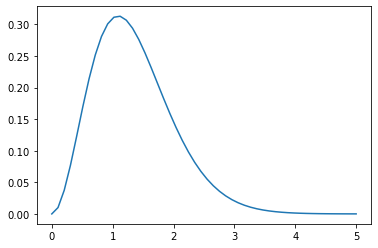

In [3]:
z = np.linspace(0,5)
plot(z, smail_nz(z))

In [4]:
# Now let's compute some Cls :-D

In [5]:
from jax.experimental.ode import odeint

In [6]:
def fun(y, a, ell):
    cosmo = cosmology()
    def smail_nz(z, a=2.0, b=1.5,z0=0.9):
        return z**a * np.exp(-(z / z0)**b)
    kernel = get_lensing_efficiency_kernel(cosmo, smail_nz)
    res = 1.0 / (cosmo.dchioverda(a) * (cosmo.f_k(a)**2) * a**4)
    res = res * kernel(a) * kernel(a) * cosmo.pl_lin(ell, a)
    return res

@jax.jit
def compute_cl(ell):
    y = odeint(fun, np.zeros_like(ell), np.array([z2a(5.), 1.0]), ell)
    return y[1]

In [8]:
ell = np.logspace(1, 3)
cl = compute_cl(ell)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [10]:
# The  first computation is slow, I'll give you that,
# but subsequent calls are pretty fast :-)
%timeit cl = compute_cl(ell)

48.6 ms ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


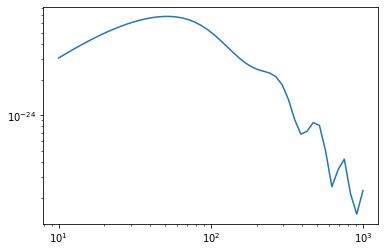

In [9]:
loglog(ell, cl)